<a href="https://colab.research.google.com/github/maktaurus/ML-Work/blob/main/Fine_Tunning_Vision_Tranformer_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,zipfile
from tensorflow.keras.utils import load_img,img_to_array


# Kaggle Section

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download gpiosenka/sports-classification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
100% 423M/424M [00:20<00:00, 23.4MB/s]
100% 424M/424M [00:20<00:00, 21.8MB/s]


In [4]:
data = zipfile.ZipFile("/content/sports-classification.zip").extractall()

# Split Datasets and Visualize

In [5]:
train_dir = os.path.join("/content/train")
val_dir = os.path.join("/content/valid")
test_dir = os.path.join("/content/test")

In [6]:
train_df = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       label_mode="int",
                                                       image_size=(224,224))
val_df = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                       label_mode="int",
                                                       image_size=(224,224))

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [7]:
class_names = train_df.class_names

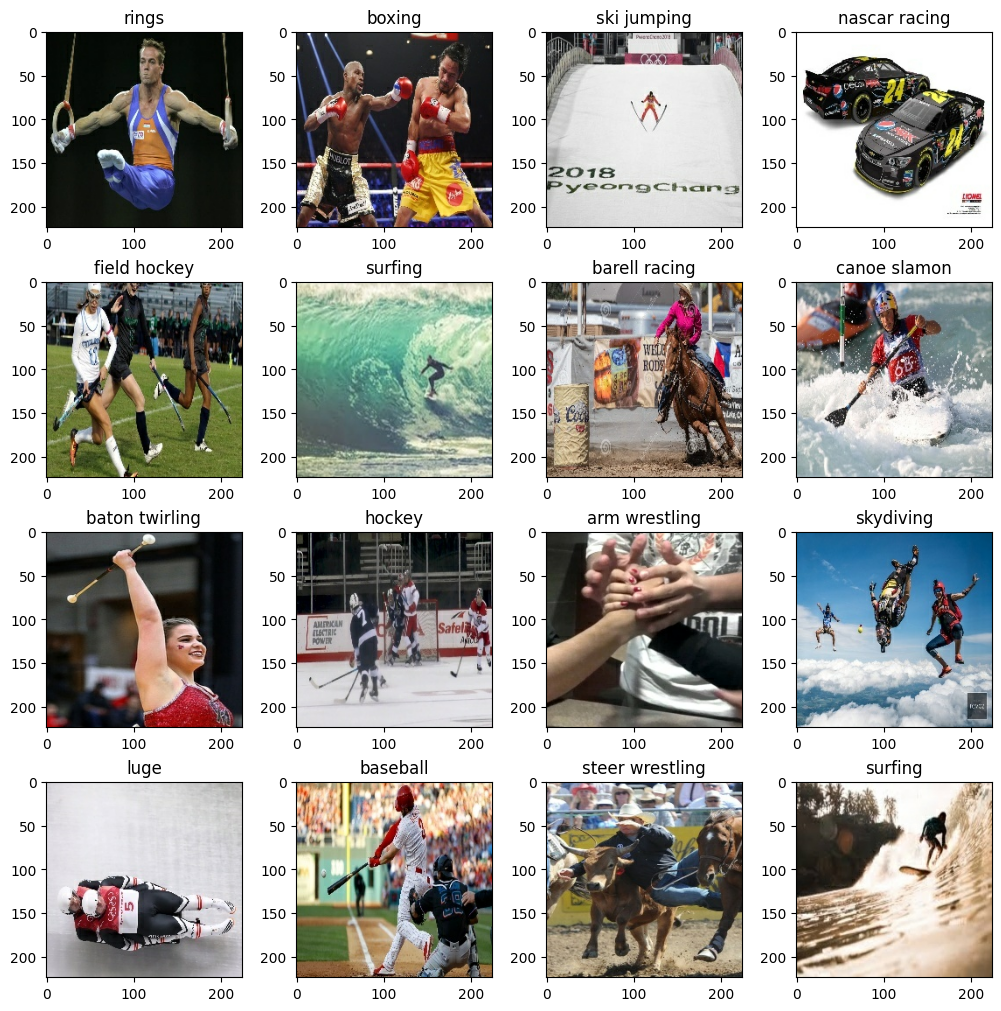

In [8]:
plt.figure(constrained_layout=True,figsize=(10,10))
for x,y in train_df.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x[i]/255)
    plt.title(class_names[y[i].numpy()])

In [9]:
def augment(image):
  img = tf.image.random_flip_left_right(image)
  img = tf.image.random_brightness(image,0.4)
  img = tf.image.random_contrast(image,0.2,0.5)
  return img

In [10]:
train_df = train_df.map(lambda x,y: (augment(x),y))

# Define Model - HuggingFace Vit Model

In [37]:
from transformers import AutoImageProcessor, TFViTModel

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Check for model output

In [54]:
img = load_img("/content/test/archery/1.jpg",target_size=(224,224))
# img = img_to_array(img)
img = tf.expand_dims(img,axis=0)
# img = tf.keras.layers.Permute((3,1,2))(img)
img = image_processor(img,return_tensors="tf")
model(img)

TFBaseModelOutputWithPooling(last_hidden_state=<tf.Tensor: shape=(1, 197, 768), dtype=float32, numpy=
array([[[ 7.32993111e-02, -2.77715735e-05, -8.73428583e-02, ...,
         -1.56032249e-01, -8.15447494e-02, -1.39213964e-01],
        [ 9.79277194e-02,  1.30690679e-01, -7.69539252e-02, ...,
         -2.23048981e-02, -2.18189850e-01, -1.54595941e-01],
        [ 7.16857165e-02,  1.41280472e-01, -8.44138116e-02, ...,
         -7.47996662e-03, -2.03991979e-01, -1.19971037e-01],
        ...,
        [ 1.07592545e-01,  3.30767445e-02, -2.01244742e-01, ...,
         -1.30018398e-01, -4.00175415e-02, -3.33317310e-01],
        [ 2.12610036e-01, -6.78500906e-03, -3.22215766e-01, ...,
         -1.20305382e-01, -1.69674292e-01, -2.51348674e-01],
        [ 1.08154908e-01, -1.19128134e-02, -2.87080437e-01, ...,
         -1.22720093e-01, -2.66118497e-01, -3.36575061e-01]]],
      dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 1.16465978e-01, -3.37664843e-01

Create a vit_model

In [55]:
input = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Resizing(224,224)(input)
x = tf.keras.layers.Rescaling(1./127.5,offset=-1)(x)
x = tf.keras.layers.Permute((3,1,2))(x)
x = model.vit(x)[1]
x = tf.keras.layers.Dense(100,activation="softmax")(x)

vit_model = tf.keras.Model(input,x)

vit_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resizing_3 (Resizing)       (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['resizing_3[0][0]']          
                                                                                                  
 permute_3 (Permute)         (None, 3, 224, 224)          0         ['rescaling_3[0][0]']         
                                                                                            

Compile and train the model

In [56]:
vit_model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

In [57]:
vit_model.fit(train_df,validation_data=val_df,epochs=2)

Epoch 1/2
422/422 [==============================] - 231s 478ms/step - loss: 1.1512 - accuracy: 0.8133 - val_loss: 0.2928 - val_accuracy: 0.9220
Epoch 2/2
422/422 [==============================] - 202s 477ms/step - loss: 0.2645 - accuracy: 0.9366 - val_loss: 0.1840 - val_accuracy: 0.9440


# Predict and visulaize

1/1 [==============================] - 0s 118ms/step


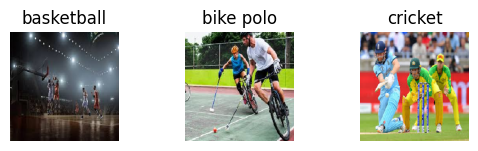

In [58]:
tt_dir = os.path.join("/content/tt/")

for i,x in enumerate(os.listdir(tt_dir)):
  img = load_img(tt_dir+x,target_size=(224,224))
  image = img_to_array(img)
  image = tf.expand_dims(img,axis=0)
  pred = vit_model.predict(image)
  obj = class_names[np.argmax(pred)]
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.title(obj)
  plt.axis("off")
